<a href="https://colab.research.google.com/github/jc-atharva/heart-failure-analysis/blob/main/heart_failure_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INTRODUCTION**

Heart failure is a chronic, progressive condition in which the heart muscle is unable to pump enough blood to meet the body's needs for blood and oxygen. Basically, the heart can't keep up with its workload. There are certain factors which increase chances of heart fail. It can be either mental or physical factors.

In this notebook, i will carry out classification with feature engineering and ensemble modeling. First of all i will display some feature analysis and in that last i will do model evalution and predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

**LOAD THE DATA**

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/jc-atharva/heart-failure-analysis/main/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Detecting the outliers

In [4]:
def detect_outliers(df,n,features):
  outlier_index=[]
  #using the tukey method for finding outliers in the dataset
  for col in features:
    q1=np.percentile(df[col],25)
    q3=np.percentile(df[col],75)
    iqr=q3-q1

    outlier_step=1.5*iqr

    outlier_list_col=df[(df[col]<q1-outlier_step) | (df[col]>q3+outlier_step)].index 
    #above line was to get a list of indices of outliers for the features column

    outlier_index.extend(outlier_list_col)

    #now we select observations containing more than 2 outliers
    outlier_index=Counter(outlier_index)
    multiple_outliers=list(k for k, v in outlier_index.items() if v>n)

    return multiple_outliers


outliers_dropped = detect_outliers(df,2, ["age","anaemia","creatinine_phosphokinase","platelets", "serum_creatinine", "serum_sodium", "time"])



**TUKEY METHOD**

It is a single-step multiple comparison procedure and statistical test. It can be used to find means that are significantly different from each other.

In [5]:
df.loc[outliers_dropped]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


In [6]:
#finding null values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

There are no missing values in the dataset.

In [7]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

**MOVING ON TO FEATURE ANALYSIS**

PART-1 : NUMERICAL ANALYSIS

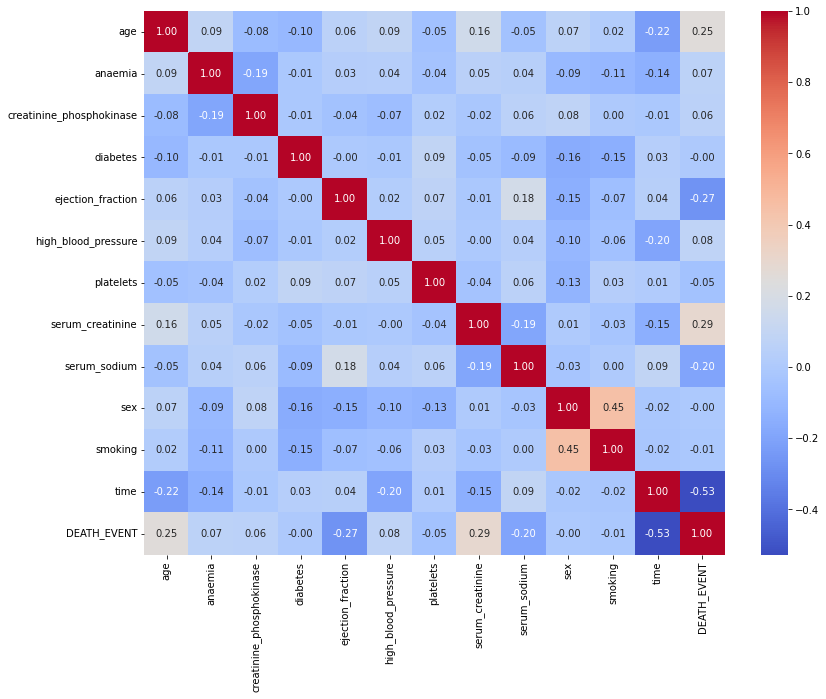

In [8]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True,fmt=".2f",cmap="coolwarm")

From the graph, we can infer that age and serum_creatinine features seem to have a significant correlation with the deat event probability whereas ejection_fraction and serum_sodium are negatively corealted with death event.

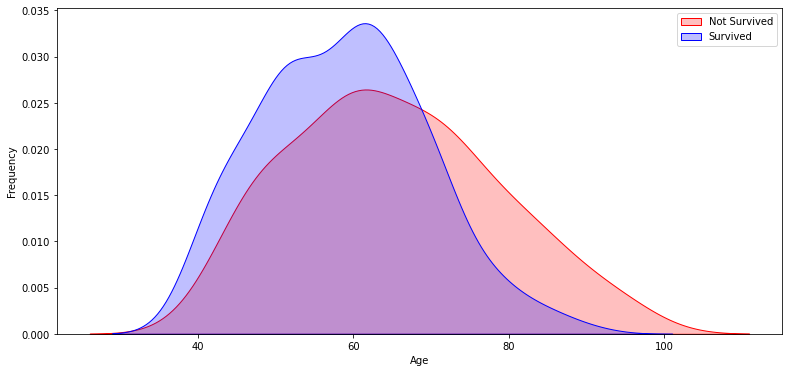

In [9]:
plt.figure(figsize=(13,6))
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 1], color="Red", shade = True)
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 0], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived","Survived"])

Through the above superimposed graph, we can clearly see a peak between 45 and 75.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


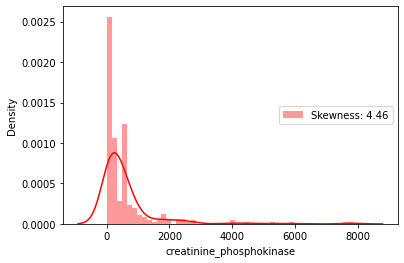

In [11]:
g=sns.distplot(df["creatinine_phosphokinase"], color='r', label="Skewness: %.2f"%(df["creatinine_phosphokinase"].skew()))
g=g.legend(loc="center right")

Above graph shows that the data for this column is skewed. 
Thus it is better to transform it with the log function to reduce this skew.

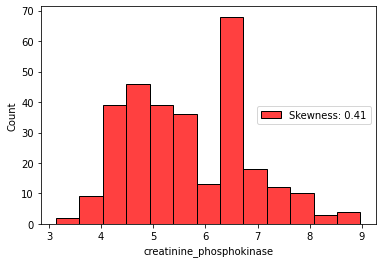

In [12]:
df["creatinine_phosphokinase"] = df["creatinine_phosphokinase"].map(lambda i: np.log(i) if i > 0 else 0)
g=sns.histplot(df["creatinine_phosphokinase"], color='r', label="Skewness: %.2f"%(df["creatinine_phosphokinase"].skew()))
g=g.legend(loc="center right")

Checking other columns for skewness


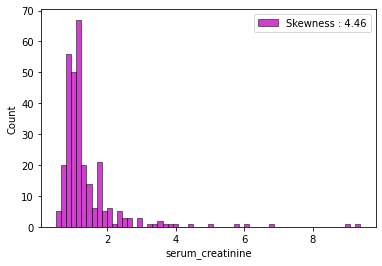

In [13]:
g = sns.histplot(df["serum_creatinine"], color="m", label="Skewness : %.2f"%(df["serum_creatinine"].skew()))
g = g.legend(loc="best")

Serum creatinine distribution is very skewed. In this case, it is better to transform it with the log function to reduce this skew.

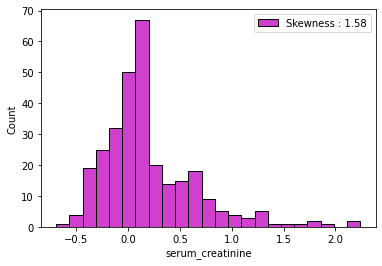

In [14]:
df["serum_creatinine"] = df["serum_creatinine"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.histplot(df["serum_creatinine"], color="m", label="Skewness : %.2f"%(df["serum_creatinine"].skew()))
g = g.legend(loc="best")

PART-2 - CATEGORICAL ANALYSIS

**ANAEMIA**

Text(0, 0.5, 'CHANCES OF SURVIVAL')

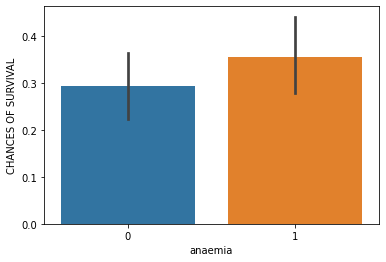

In [15]:
g = sns.barplot(x="anaemia",y="DEATH_EVENT",data=df)
g.set_ylabel("CHANCES OF SURVIVAL")

**SEX**

Text(0, 0.5, 'CHANCES OF SURVIVAL')

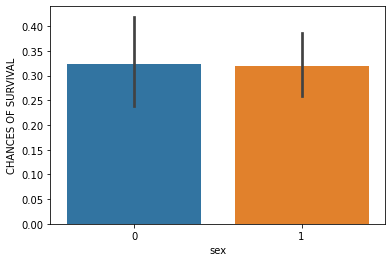

In [16]:
g = sns.barplot(x="sex",y="DEATH_EVENT",data=df)
g.set_ylabel("CHANCES OF SURVIVAL")

In [17]:
df[["sex","DEATH_EVENT"]].groupby('sex').mean()

,DEATH_EVENT
sex,
0,0.323810
1,0.319588


Here, male patients are classified as 0 and females are classified as 1.
Since, both sexes have similar chances of survival thus we can conclude that the sex of the individual plays no important role in our analysis.

**DIABETES**

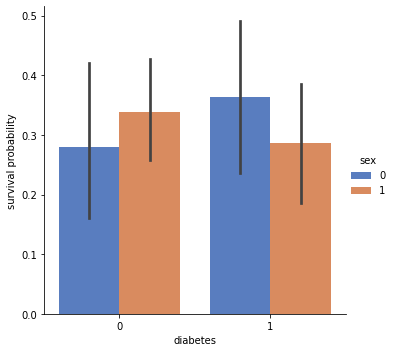

In [18]:
g = sns.catplot(x="diabetes", y="DEATH_EVENT", hue="sex", data=df,kind="bar", palette="muted")
g.set_ylabels("survival probability")

This graph clearly shows us that females with diabetes have greater chances of heart failure.

**BLOOD PRESSURE**

Text(0, 0.5, 'Survival Probability')

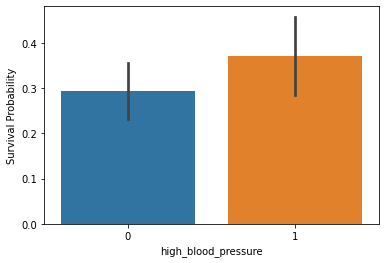

In [19]:
g = sns.barplot(x="high_blood_pressure",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

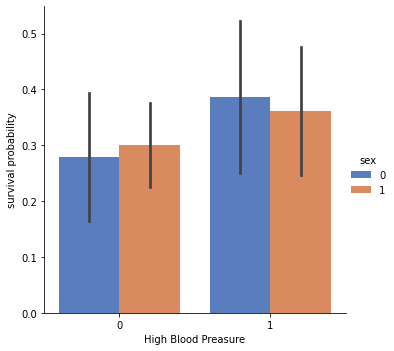

In [20]:
g = sns.catplot(x="high_blood_pressure", y="DEATH_EVENT", hue="sex", data=df,kind="bar", palette="muted")
g.set_ylabels("survival probability")
g.set_xlabels("High Blood Preasure")

Females with high blood preasure have more chances of heart failure and females who do not have high blood preasure have very less chance of dying.

**SERUM SODIUM/SMOKING**

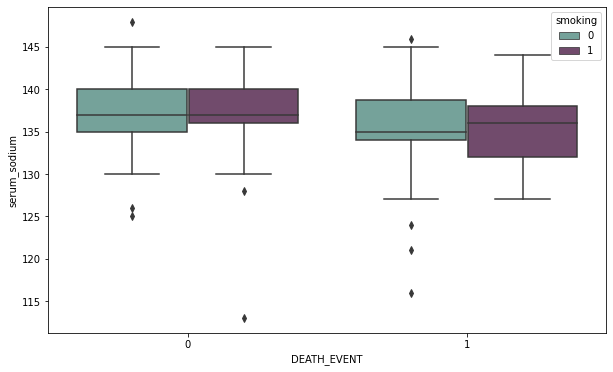

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df["DEATH_EVENT"], y=df['serum_sodium'], hue=df['smoking'], palette=["#6daa9f","#774571"])
plt.show()

There is knowN correlation between smoking and Serum Sodium. Compared to non-smokerS, smokers had significantly increased levels of serum sodium.

https://www.researchgate.net/publication/259625450_Effect_of_cigarette_smoking_on_blood_sodium_and_potassium_levels_in_sudanese_subjects

**Platelets vs Anemia vs Death Event**

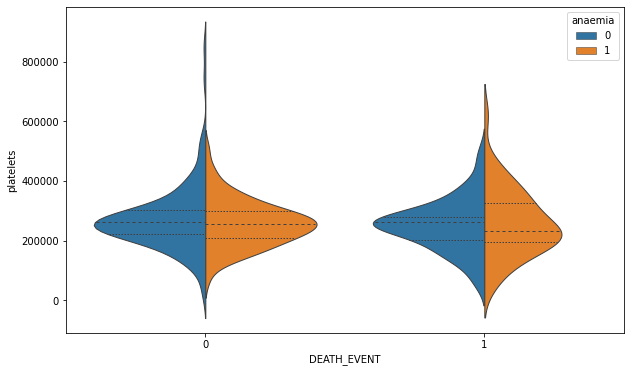

In [22]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="DEATH_EVENT", y="platelets", hue="anaemia",split=True, inner="quart", linewidth=1,)

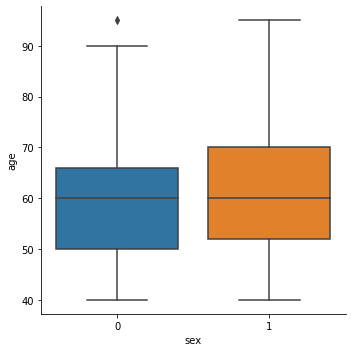

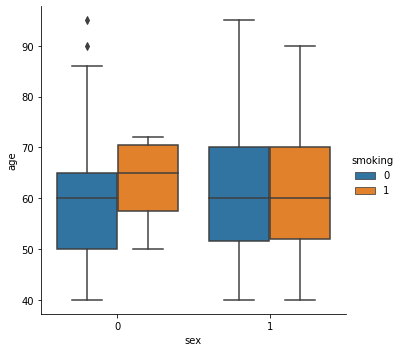

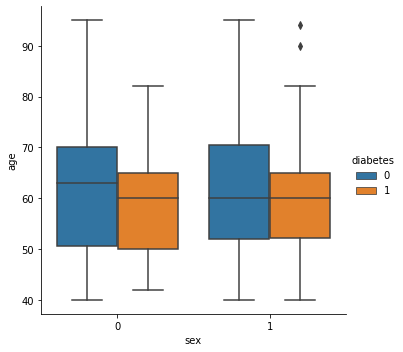

In [23]:
sns.catplot(y="age",x="sex",data=df,kind="box")
sns.catplot(y="age",x="sex",hue="smoking", data=df,kind="box")
sns.catplot(y="age",x="sex",hue="diabetes", data=df,kind="box")

# FEATURE ENGINEERING

**CREATING CATERGORICAL VALUES**

In [24]:
df = pd.get_dummies(df, columns = ["anaemia"], prefix="ena")
df = pd.get_dummies(df, columns = ["diabetes"], prefix="dia")
df = pd.get_dummies(df, columns = ["high_blood_pressure"], prefix="hbp")
df = pd.get_dummies(df, columns = ["sex"], prefix="sex")
df = pd.get_dummies(df, columns = ["smoking"], prefix="smk")

In [25]:
df.time.value_counts()

187    7
250    7
186    6
107    6
10     6
      ..
135    1
140    1
148    1
150    1
4      1
Name: time, Length: 148, dtype: int64

# MODELLING

**DATA SPLITTING**

In [26]:
features = df.drop(["DEATH_EVENT"], axis=1)
labels = df["DEATH_EVENT"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

**CROSS VALIDATE MODELS**

Comparing 7 popular classification models and evaluating the mean accuracy by kfold cross validation procedure



*   Logistic Regression
*   Decision Tree
*   AdaBoost
*   Random Forest
*   Gradient Boosting
*   KNN
*   SVC









In [27]:
def evaluate_model(models):
   
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        result.append(cross_val_score(model, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "KNeighborsClassifier"
        ]
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df


,CrossValMeans,CrossValerrors,Models
0,0.804286,0.095818,LogisticRegression
1,0.760238,0.046438,DecisionTreeClassifier
2,0.775000,0.037815,AdaBoostClassifier
3,0.660238,0.014602,SVC
4,0.799048,0.073086,RandomForestClassifier
5,0.798571,0.077899,GradientBoostingClassifier
6,0.660714,0.067185,KNeighborsClassifier


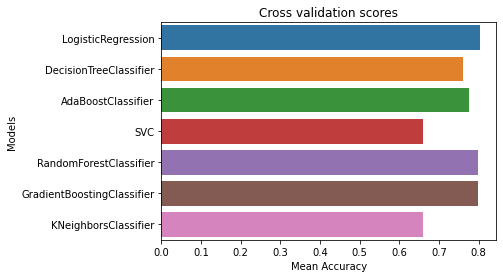

In [28]:
random_state = 30
models = [
    LogisticRegression(random_state = random_state),
    DecisionTreeClassifier(random_state = random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.2),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    KNeighborsClassifier(),
]
evaluate_model(models)